# Plot results

In [50]:
using Glob
using Dates
using ColorSchemes
using NCDatasets
using CairoMakie, GeoMakie
using GeoDatasets
using GeometryOps, GeoInterface
include("./config.jl")
using JupyterFormatter
enable_autoformat()

6-element Vector{Function}:
 format_current_cell (generic function with 1 method)
 format_current_cell (generic function with 1 method)
 format_current_cell (generic function with 1 method)
 format_current_cell (generic function with 1 method)
 format_current_cell (generic function with 1 method)
 format_current_cell (generic function with 1 method)

In [44]:
varname = "Water_body_phosphate"
depth2plot = 100
month2plot = 10
cmap = cgrad(:RdYlBu, rev = true)
cmaperror = cgrad(:RdYlGn_10, 10, rev = true, categorical = true)

## Files and directories

In [3]:
databasedir = "/home/ctroupin/data/EMODnet-Chemistry/Eutrophication2024/Results/"
datadir = joinpath(databasedir, "../netCDF")
casename = "$(varname)-res-0.25-epsilon2-2.0-varlen1-lb5-maxit-5000-reltol-1.0e-9-bathcl-go-exclude-mL-1960-exNS2-monthly"
resultfile = joinpath(databasedir, casename, "Results/$(varname)_monthly.nc")
isfile(resultfile), isdir(datadir)

(true, true)

In [19]:
lon, lat, depth, dates, field, error =
    read_results(resultfile, varname, depth2plot, month2plot);

## WOA fields

In [20]:
woafile = joinpath(woadir, "woa23_all_p$(lpad(month2plot, 2, '0'))_01.nc")
if isfile(woafile)
    lonwoa, latwoa, depthwoa, dateswoa, fieldwoa, errorwoa =
        read_woa(woafile, varname, depth2plot, lonr, latr)
else
    @warn("$(woafile) does not exist")
end

(Float32[-44.5, -43.5, -42.5, -41.5, -40.5, -39.5, -38.5, -37.5, -36.5, -35.5  …  60.5, 61.5, 62.5, 63.5, 64.5, 65.5, 66.5, 67.5, 68.5, 69.5], Float32[24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5, 33.5  …  73.5, 74.5, 75.5, 76.5, 77.5, 78.5, 79.5, 80.5, 81.5, 82.5], Float32[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0  …  425.0, 450.0, 475.0, 500.0, 550.0, 600.0, 650.0, 700.0, 750.0, 800.0], [DateTime("1993-10-16T22:21:33.610")], AbstractFloat[0.0647345f0 0.06553151f0 … NaN NaN; 0.06581503f0 0.06603334f0 … NaN NaN; … ; NaN NaN … 0.7360439f0 0.69386774f0; NaN NaN … 0.7226594f0 0.6808049f0], AbstractFloat[NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN])

## Make the plots
### DIVAnd

In [21]:
f1 = plot_field_var(varname, lon, lat, field, depth2plot, month2plot, "DIVAnd", cmap)
save(joinpath(figdir, "$(varname)_depth-$(depth2plot)_month-$(month2plot)_DIVAnd.png"), f1)

CairoMakie.Screen{IMAGE}


### WOA

In [22]:
f2 = plot_field_var(varname, lonwoa, latwoa, fieldwoa, depth2plot, month2plot, "WOA", cmap)
save(joinpath(figdir, "$(varname)_depth-$(depth2plot)_month-$(month2plot)_WOA.png"), f2)

CairoMakie.Screen{IMAGE}


## Plot all the annex fields

In [37]:
resultfile = "/home/ctroupin/data/EMODnet-Chemistry/Eutrophication2024/Results/Monthly/Water_body_phosphate.nc"
ds = NCDataset(resultfile, "r")
# print(ds)
lon = ds["lon"][:]
lat = ds["lat"][:]
depth = ds["depth"][:]
dates = ds["time"][:]

# Subsetting
depthindex = findfirst(depth .== depth2plot)
timeindex = findfirst(Dates.month.(dates) .== month2plot)
# Read gridded field and error
field = coalesce.(ds[varname][:, :, depthindex, timeindex], NaN)
fielderror = coalesce.(ds[varname*"_relerr"][:, :, depthindex, timeindex], NaN)
fieldL1 = coalesce.(ds[varname*"_L1"][:, :, depthindex, timeindex], NaN)
fieldL2 = coalesce.(ds[varname*"_L1"][:, :, depthindex, timeindex], NaN)
fielddeepest = coalesce.(ds[varname*"_deepest"][:, :, timeindex], NaN)

close(ds)

closed Dataset

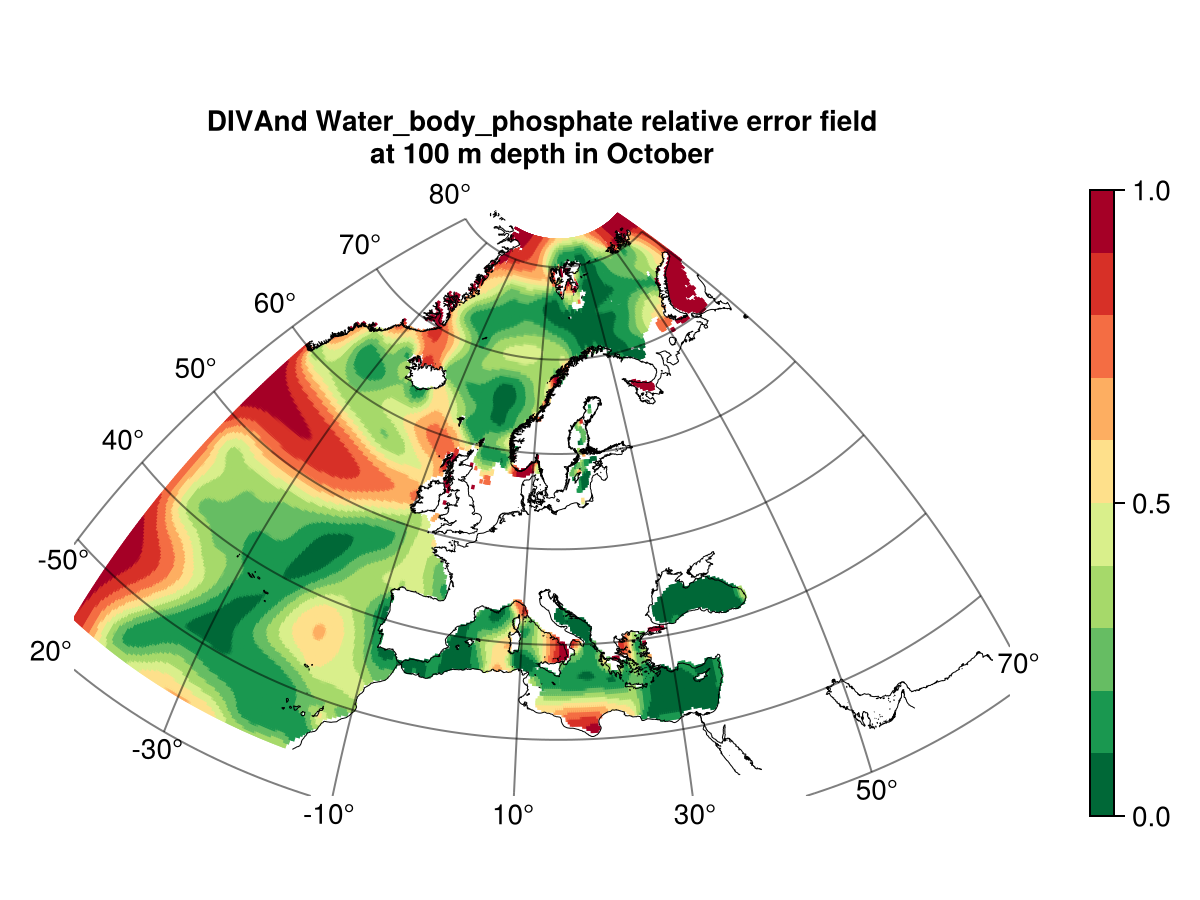

CairoMakie.Screen{IMAGE}


In [51]:

f1, ga1, hm1 = plot_field_var_fast(
    varname,
    lon,
    lat,
    fielddeepest,
    depth2plot,
    month2plot,
    "DIVAnd",
    cmap,
)
hm1.colorrange = (0.0, 10.0)
ga1.title = "DIVAnd deepest value of $(varname)\nin $(Dates.monthname(month2plot))\n\n"
display(f1)


f2, ga2, hm2 =
    plot_field_var_fast(varname, lon, lat, fieldL1, depth2plot, month2plot, "DIVAnd", cmap)
hm2.colorrange = (0.0, 1)
ga2.title = "DIVAnd $(varname) field masked using a 30% relative error threshold\nat $(Int64(depth2plot)) m depth in $(Dates.monthname(month2plot))\n\n"
display(f2)


f3, ga3, hm3 =
    plot_field_var_fast(varname, lon, lat, fieldL2, depth2plot, month2plot, "DIVAnd", cmap)
hm3.colorrange = (0.0, 1)
ga3.title = "DIVAnd $(varname) field masked using a 50% relative error threshold\nat $(Int64(depth2plot)) m depth in $(Dates.monthname(month2plot))\n\n"
display(f3)

f4, ga4, hm4 = plot_field_var(
    varname,
    lon,
    lat,
    fielderror,
    depth2plot,
    month2plot,
    "DIVAnd",
    cmaperror,
)
hm4.colorrange = (0.0, 1)
hm4.highclip = nothing
ga4.title = "DIVAnd $(varname) relative error field\nat $(Int64(depth2plot)) m depth in $(Dates.monthname(month2plot))\n\n"
display(f4)